In [1]:
# from nnAudio import Spectrogram
import sys
sys.path.insert(0,'../Installation/nnAudio')
import Spectrogram
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from helperfunctions import get_dummy_dataset

from sklearn.model_selection import train_test_split
import torch
import torchvision

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
X, Y = get_dummy_dataset()

100%|██████████| 10925/10925 [00:39<00:00, 279.88it/s]


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y.reshape(-1,1), test_size=0.2, random_state=101)

In [4]:
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, device='cpu'), torch.tensor(Y_train, device='cpu'))
testset = torch.utils.data.TensorDataset(torch.tensor(X_test, device='cpu'), torch.tensor(Y_test, device='cpu'))

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512)
testloader = torch.utils.data.DataLoader(testset, batch_size=512)

In [49]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.cqt = Spectrogram.CQT1992v2(sr=44100, hop_length=512, fmin=200,
                                     n_bins=82, bins_per_octave=12,
                                     norm=1, window='hann',
                                     center=True, pad_mode='constant', trainable=False)
        self.CNN_layer1 = torch.nn.Conv2d(1,1, kernel_size=(4,4))
        self.CNN_layer2 = torch.nn.Conv2d(1,1, kernel_size=(4,4))
        
        self.regressor = torch.nn.Linear(76*12,1)

    def forward(self, x):
        x = self.cqt(x)
        x = self.CNN_layer1(x.unsqueeze(1))
        x = self.CNN_layer2(x)
#         print(x.shape)
        x = x.view(x.data.size()[0], 76*12)
        x = self.regressor(torch.relu(x))
        return torch.sigmoid(x)

In [50]:
model = Model()
model.cuda()

CQT kernels created, time used = 0.0245 seconds


Model(
  (cqt): CQT1992v2()
  (CNN_layer1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (CNN_layer2): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (regressor): Linear(in_features=912, out_features=1, bias=True)
)

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)
loss_function = torch.nn.MSELoss() 

# Visualizing Original Weights

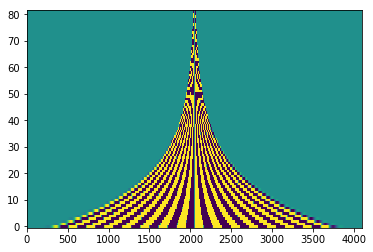

In [52]:
original_basis_real = model.cqt.cqt_kernels_real.cpu().detach().numpy().squeeze(1)
original_basis_imag = model.cqt.cqt_kernels_imag.cpu().detach().numpy().squeeze(1)
plt.imshow(original_basis_imag, aspect='auto', origin='lower', vmin=-1e-5,vmax=1e-5)

# Traiing Model

In [53]:
loss_train = []
loss_test = []

print("epoch\ttrain loss\ttest loss")
for e in range(60):
    loss_train_e = 0.0
    loss_test_e = 0.0

    for i, (x, y) in enumerate(trainloader):
        x = x.cuda()
        y = y.cuda()/110240 # Normalizing to labels to [0,1]
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        loss.backward() # Calculating gradient
        optimizer.step() # Updating paramenters by gradient
        loss_train_e += loss.item()
        print(f"training {i}/{len(trainloader)} batches, loss = {loss.item():.6f}", end = '\r')
    loss_train.append(loss_train_e/len(trainloader))
   
    with torch.no_grad():
        for x, y in testloader:
            x = x.cuda()
            y = y.cuda()/110240
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            loss_test_e +=loss.item()
        loss_test.append(loss_test_e/len(testloader))
        print(' '*100, end='\r')
        print(f"{e}\t{loss_train[-1]:.6f}\t{loss_test[-1]:.6f}")

epoch	train loss	test loss
0	0.081465	0.080600                                                                                 
1	0.081272	0.080433                                                                                 
2	0.081095	0.080236                                                                                 
3	0.080879	0.079999                                                                                 
4	0.080619	0.079716                                                                                 
5	0.080311	0.079383                                                                                 
6	0.079952	0.078996                                                                                 
7	0.079537	0.078552                                                                                 
8	0.079063	0.078048                                                                                 
9	0.078528	0.077482                                             

# Visualizing Trained Weights

In [54]:
trained_basis_real = model.cqt.cqt_kernels_real.cpu().detach().numpy().squeeze(1)
trained_basis_imag = model.cqt.cqt_kernels_imag.cpu().detach().numpy().squeeze(1)

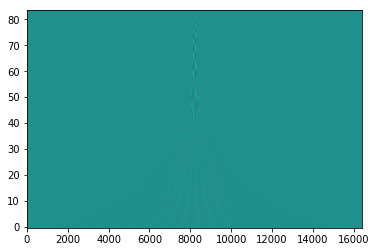

In [26]:
plt.imshow(trained_basis_imag, aspect='auto', origin='lower')

In [27]:
np.save('nontrainable_cqt', loss_test)

# Have a closer look on the STFT basis

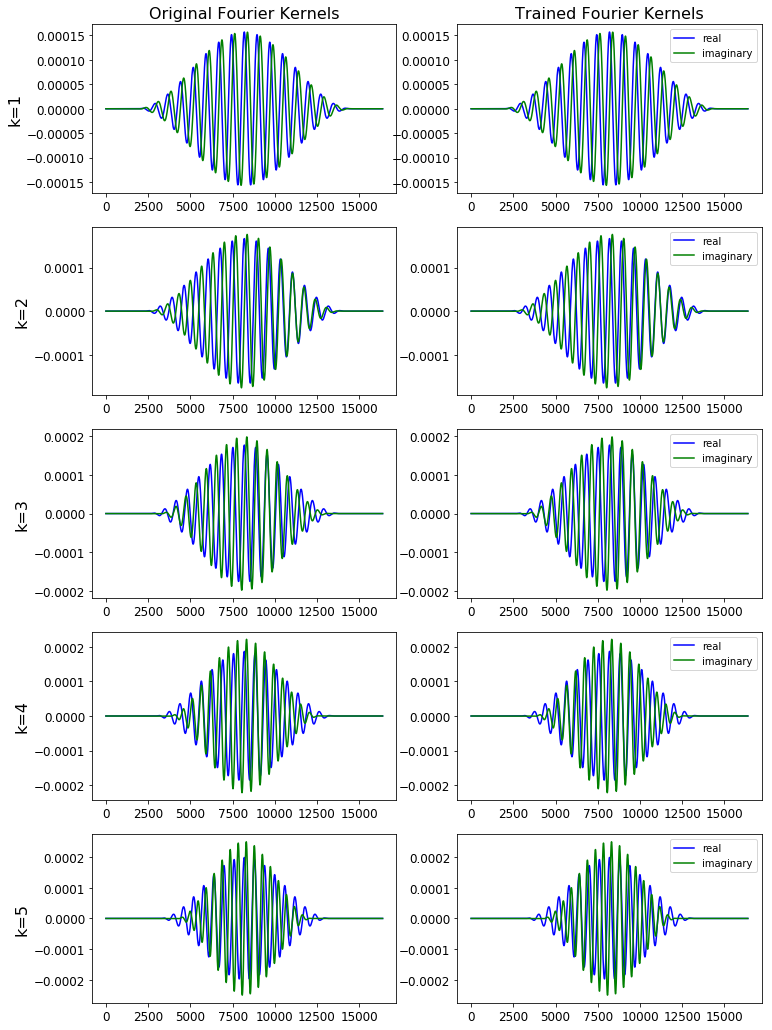

In [28]:
fig, ax = plt.subplots(5,2, figsize=(12,18))
cols = ['Original Fourier Kernels', 'Trained Fourier Kernels']
rows = np.arange(1,6)
for ax_idx, col in zip(ax[0], cols):
    ax_idx.set_title(col, size=16)
for ax_idx, row in zip(ax[:,0], rows):
    ax_idx.set_ylabel(f'k={row}', size=16)    
    

for i in range(5):
    ax[i,0].plot(original_basis_real[i+1], 'b')
    ax[i,1].plot(trained_basis_real[i+1], 'b')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    
for i in range(5):
    ax[i,0].plot(original_basis_imag[i*2+1], 'g')
    ax[i,1].plot(trained_basis_imag[i*2+1], 'g')
    ax[i,0].tick_params(labelsize=12)
    ax[i,1].tick_params(labelsize=12)
    ax[i,1].legend(['real','imaginary'])


Text(0.5, 1.0, 'Trained STFT')

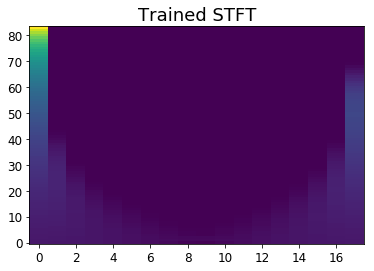

In [29]:
plt.imshow(model.cqt(x)[0].cpu().detach().numpy(), aspect='auto', origin='lower')
plt.tick_params(labelsize=12)
plt.title('Trained STFT', size=18)

In [17]:
    self.cqt = Spectrogram.CQT1992v2(sr=44100, hop_length=512, fmin=55,
                             n_bins=84, bins_per_octave=12,
                             norm=1, window='hann',
                             center=True, pad_mode='reflect', trainable=True)

STFT kernels created, time used = 0.0029 seconds


Text(0.5, 1.0, 'Original STFT')

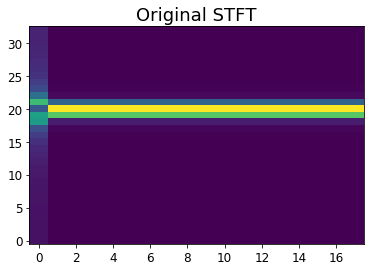

In [18]:
plt.imshow(ori_stft(x)[0].cpu().detach().numpy(), aspect='auto', origin='lower')
plt.tick_params(labelsize=12)
plt.title('Original STFT', size=18)

In [66]:
y*110240

tensor([[ 67950.0000],
        [ 89540.0000],
        [ 41250.0000],
        [ 18600.0000],
        [ 65950.0000],
        [ 38170.0000],
        [108489.9922],
        [ 68980.0000],
        [108870.0000],
        [104680.0000],
        [ 59519.9961],
        [ 81920.0000],
        [ 62539.9961],
        [  2290.0000],
        [ 57450.0000],
        [ 74129.9922],
        [ 54180.0000],
        [ 76649.9922],
        [ 70760.0000],
        [104620.0000],
        [ 60940.0000],
        [105250.0000],
        [ 76489.9922],
        [ 98270.0000],
        [ 31739.9980],
        [ 65200.0000],
        [105790.0000],
        [104840.0000],
        [ 22660.0000],
        [  5280.0000],
        [ 13939.9990],
        [ 14019.9990],
        [ 11399.9990],
        [ 94240.0000],
        [ 65729.9922],
        [ 95479.9922],
        [109540.0000],
        [105690.0000],
        [ 57540.0000],
        [ 75050.0000],
        [ 72539.9922],
        [  7910.0000],
        [ 21610.0000],
        [ 3